```# Instructions:
# 1. Set runtime to T4 GPU.
# 2. Install dependencies.
# 3. Mount Drive to save to My Drive/JU-Astrophysics/KdV-Soliton-PINN/.
# 4. Place pre-generated pred_test.txt and exact_test.txt in the folder if provided.
# 5. Ensure ~50MB free space.

```



In [1]:
!sudo dpkg --configure -a

In [2]:
!pip install deepxde
!apt-get update
!apt-get install -y texlive texlive-latex-extra texlive-fonts-extra cm-super dvipng

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.7 MB/s eta 0:00:00
Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,607 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease [24.3 kB]
Hit:11 https://ppa.launchp

In [3]:
# Import Packages
import numpy as np
import tensorflow as tf
import deepxde as dde
from scipy.interpolate import griddata
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Create save directory
save_dir = '/content/drive/MyDrive/JU-Astrophysics/KdV-Soliton-PINN'
os.makedirs(save_dir, exist_ok=True)

# Define the domain
x_lower, x_upper = -20.0, 20.0
t_lower, t_upper = 0.0, 20.0  # t_lower is non-negative

# Create the 2D grid (for plotting and input)
x = np.linspace(x_lower, x_upper, 160)  # Reduced resolution
t = np.linspace(t_lower, t_upper, 250)  # Reduced resolution
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

# Space and time domains/geometry (for the deepxde model)
space_domain = dde.geometry.Interval(x_lower, x_upper)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)

# Soliton parameters
# B = 1.0  # Adjusted for faster speed
# a = 0.193238
# b = 0.00785425
# A = (12 * b * B**2) / a  # ≈ 0.487284
# c = 4 * b * B**2  # ≈ 0.031417
a = 6
b = 1

# Physics-Informed Part
def pde(x, y):
    u = y[:, 0:1]
    # In 'jacobian', i is the output component and j is the input component
    u_t = dde.grad.jacobian(y, x, j=1)  # Derivative of u with respect to t
    u_x = dde.grad.jacobian(y, x, j=0)  # Derivative of u with respect to x
    u_xx = dde.grad.jacobian(u_x, x, j=0)  # Second derivative of u with respect to x
    u_xxx = dde.grad.jacobian(u_xx, x, j=0)  # Third derivative of u with respect to x

    # KdV equation: u_t + a*u*u_x + b*u_xxx = 0
    f_u = u_t + a * u * u_x + b * u_xxx

    return f_u

# Initial and Boundary conditions using Dirichlet BC
def boun_1(x):
    T = x[:, 1:2]
    return 0.5 * (1 / np.cosh(0.5 * (x_lower - T)))**2

def boun_2(x):
    T = x[:, 1:2]
    return 0.5 * (1 / np.cosh(0.5 * (x_upper - T)))**2

def init_1(x):
    X = x[:, 0:1]
    return 0.5 * (1 / np.cosh(0.5 * X))**2  # Initial condition at t = 0

# Boundary and initial conditions
bc_1 = dde.DirichletBC(geomtime, boun_1, lambda _, on_boundary: on_boundary, component=0)
bc_2 = dde.DirichletBC(geomtime, boun_2, lambda _, on_boundary: on_boundary, component=0)
ic_1 = dde.IC(geomtime, init_1, lambda _, on_initial: on_initial, component=0)

# Create data for NN
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_1, bc_2, ic_1],
    num_domain=20000,
    num_boundary=150,
    num_initial=150,
    train_distribution="pseudo",
)

# Network architecture
net = dde.maps.FNN([2] + [25] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

# Compile and train with Adam optimizer
model.compile("adam", lr=1e-3, loss="MSE")
model.train(iterations=10000, display_every=1000)

# L-BFGS Optimization
dde.optimizers.config.set_LBFGS_options(
    maxcor=50,
    ftol=1.0 * np.finfo(float).eps,
    gtol=1e-08,
    maxiter=5000,
    maxfun=5000,
    maxls=50,
)
model.compile("L-BFGS")
model.train()
# model.save(checkpoint_path + "_lbfgs")

# Predict in chunks to avoid OOM
prediction = model.predict(X_star, operator=None)
u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")

# Exact solution for the KdV equation (soliton solution)
exact = 0.5 * (1 / np.cosh(0.5 * (X - T)))**2

# Save data to Google Drive
np.savetxt(f"{save_dir}/pred_test.txt", u, fmt="%.6e")
np.savetxt(f"{save_dir}/exact_test.txt", exact, fmt="%.6e")


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


No backend selected.
Finding available backend...
Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



Mounted at /content/drive
Compiling model...
Building feed-forward neural network...
'build' took 0.117461 s

'compile' took 1.289086 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [4.75e-03, 1.12e-01, 1.67e-01, 2.55e-02]    [4.75e-03, 1.12e-01, 1.67e-01, 2.55e-02]    []  
1000      [1.73e-04, 5.52e-03, 5.90e-03, 1.62e-05]    [1.73e-04, 5.52e-03, 5.90e-03, 1.62e-05]    []  
2000      [1.12e-04, 5.57e-03, 5.84e-03, 3.79e-06]    [1.12e-04, 5.57e-03, 5.84e-03, 3.79e-06]    []  
3000      [9.23e-05, 5.59e-03, 5.81e-03, 1.43e-06]    [9.23e-05, 5.59e-03, 5.81e-03, 1.43e-06]    []  
4000      [7.88e-05, 5.62e-03, 5.78e-03, 8.47e-07]    [7.88e-05, 5.62e-03, 5.78e-03, 8.47e-07]    []  
5000      [6.85e-05, 5.61e-03, 5.79e-03, 3.47e-07]    [6.85e-05, 5.61e-03, 5.79e-03, 3.47e-07]    []  
6000      [6.73e-05, 5.82e-03, 5.61e-03, 1.80e-05]    [6.73e-05, 5.82e-03, 5.61e-03, 1.80e-05]    []  
7000      [5.

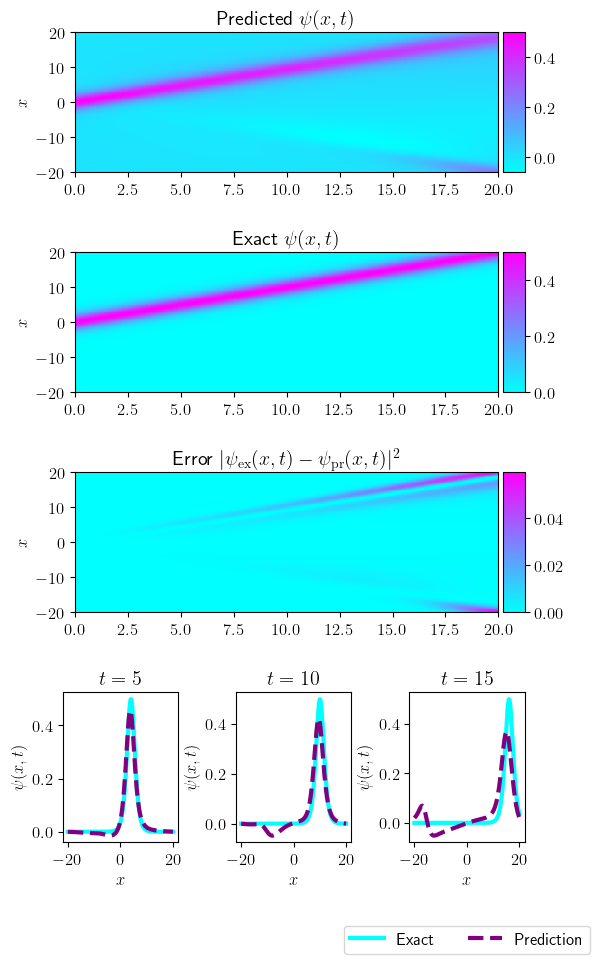

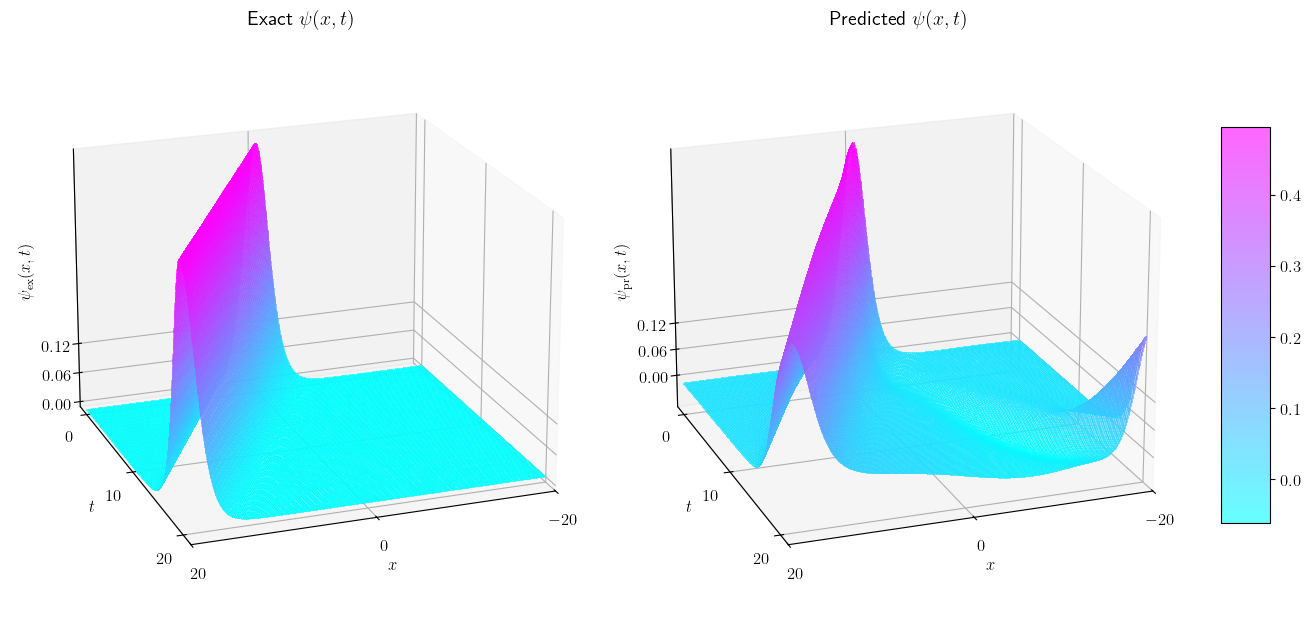

In [ ]:
# Import Packages
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import rc
import matplotlib.transforms as mtransforms
from google.colab import drive
import os

# # Mount Google Drive
# drive.mount('/content/drive')

# # Create save directory
# save_dir = '/content/drive/MyDrive/JU-Astrophysics/KdV-Soliton-PINN'
# os.makedirs(save_dir, exist_ok=True)

# Set font and style
fn = [12]
plt.rcParams.update({'font.size': fn[0], 'text.color': 'black', 'font.weight': 'bold'})
csfont = {'fontname': 'serif'}
hfont = {'fontname': 'serif'}
plt.rcParams['text.usetex'] = True

# Load Data
u = np.loadtxt(f"{save_dir}/pred_test.txt", dtype=np.float32)
ext = np.loadtxt(f"{save_dir}/exact_test.txt", dtype=np.float32)

# Define the grid
n_t, n_x = u.shape
x = np.linspace(x_lower, x_upper, n_x)  # Reduced resolution
t = np.linspace(t_lower, t_upper, n_t)  # Reduced resolution
X, T = np.meshgrid(x, t)

# Calculate error
err = np.abs(u - ext)**2
rel_err = np.abs(u - ext)/ext

# Create the figure
fig, ax = plt.subplots(figsize=(6, 10))
ax.axis('off')

cmap_name = "cool"

####### Row 0: Predicted Solution ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=0.8, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(u.T, interpolation='nearest', cmap=cmap_name,
              extent=[0, 20, -20, 20],  # Adjusted time domain
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
ax.set_title(r'Predicted $\psi(x,t)$')
ax.set_ylabel(r'$x$')
# ax.set_xlabel(r'$t$')

####### Row 1: Exact Solution ##################
gs1 = gridspec.GridSpec(1, 2)
gs1.update(top=0.72, bottom=0.58, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs1[:, :])

h = ax.imshow(ext.T, interpolation='nearest', cmap=cmap_name,
              extent=[0, 20, -20, 20],  # Adjusted time domain
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_title(r'Exact $\psi(x,t)$')
ax.set_ylabel(r'$x$')
# ax.set_xlabel(r'$t$')

####### Row 2: Error ##################
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=0.5, bottom=0.36, left=0.15, right=0.9, wspace=0.2)
ax = plt.subplot(gs2[:, :])

h = ax.imshow(err.T, interpolation='nearest', cmap=cmap_name,
              extent=[0, 20, -20, 20],  # Adjusted time domain
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_title(r'Error $|\psi_{\rm{ex}}(x,t) - \psi_{\rm{pr}}(x,t)|^2$')
# ax.set_title(r'Relative error $|\psi_{\rm{ex}}(x,t) - \psi_{\rm{pr}}(x,t)|/\psi_{\rm{ex}}(x,t)$')
ax.set_ylabel(r'$x$')
# ax.set_xlabel(r'$t$')

####### Row 3: Line Plots ##################
gs3 = gridspec.GridSpec(1, 3)
gs3.update(top=0.28, bottom=0.13, left=0.13, right=0.9, wspace=0.5)

# Define the time points and corresponding indices
time_points = [5, 10, 15]  # Time points to plot
indices = [50, 125, 200]   # Corresponding indices in the data

# Loop through the time points and plot
for i, (t_val, idx) in enumerate(zip(time_points, indices)):
    ax = plt.subplot(gs3[0, i])
    ax.plot(x, ext[idx], c='cyan', ls='-', linewidth=3, label='Exact')
    ax.plot(x, u[idx], c="purple", ls='--', linewidth=3, label='Prediction')
    ax.set_ylabel(r'$\psi(x,t)$')
    ax.set_xlabel(r'$x$')
    ax.set_title(f'$t = {t_val}$')

# Add a single legend for all subplots of the loop
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.5), ncol=5, frameon=True)

# Save and show the figure
plt.savefig(f"{save_dir}/KdV_Soliton_2D_test.jpg", dpi=600)
plt.show()

####### 3D Plots ##################
fig = plt.figure(figsize=(13, 8), constrained_layout=True)

# Exact Solution 3D Plot
ax = fig.add_subplot(121, projection='3d')
surf = ax.plot_surface(X, T, ext, linewidth=0, cmap=cmap_name, antialiased=False, alpha=0.6, rcount=200, ccount=200)
ax.view_init(20, 70)
ax.set_xticks([-20, 0, 20])
ax.set_xlabel(r'$x$')
ax.set_xlim(-20, 20)
ax.set_yticks([0, 10, 20])
ax.set_ylabel(r'$t$')
ax.set_zticks([0.00, 0.06, 0.12])
# disable auto rotation
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\psi_{\rm{ex}}(x,t)$', rotation=90)
ax.set_title(r'Exact $\psi(x,t)$')

# Predicted Solution 3D Plot
ax = fig.add_subplot(122, projection='3d')
surf = ax.plot_surface(X, T, u, linewidth=0, cmap=cmap_name, antialiased=False, alpha=0.6, rcount=200, ccount=200)
ax.view_init(20, 70)
ax.set_xticks([-20, 0, 20])
ax.set_xlabel(r'$x$')
ax.set_xlim(-20, 20)
ax.set_yticks([0, 10, 20])
ax.set_ylabel(r'$t$')
ax.set_zticks([0.00, 0.06, 0.12])
# disable auto rotation
ax.zaxis.set_rotate_label(False)
ax.set_zlabel(r'$\psi_{\rm{pr}}(x,t)$', rotation=90)
ax.set_title(r'Predicted $\psi(x,t)$')

# Add colorbar
fig.colorbar(surf, shrink=0.5, aspect=8)

# Save and show the figure
plt.savefig(f"{save_dir}/KdV_Soliton_3D_test.jpg", dpi=600)
plt.show()
